In [1]:
from imports import *
from agents import BetaAgent
from model import Model
from network_utils import *
from network_randomization import *
from network_generation import *
from simulation_functions import *

# Testing

In [2]:
n_simulations = 100
G_default = barabasi_albert_directed(100,5)

num_cores = cpu_count()  # Get the number of available CPU cores
print(num_cores)

# Define a partial function to pass G_perceptron to generate_parameters_empir
# This ensures that generate_parameters_empir is called with the correct argument within the pool
# The 'partial' function allows you to create a new function with some of the arguments pre-filled.
from functools import partial
generate_params_with_G = partial(generate_parameters, G=G_default)

with Pool(num_cores) as pool:
    # Use tqdm to display a progress bar
    # Now, 'generate_params_with_G' is the function that will be executed by each worker.
    # Each worker will receive an index from 'range(n_simulations)' as its argument,
    # which is ignored in 'generate_params_with_G' but is required by the 'imap_unordered' function.
    param_dict = list(tqdm.tqdm(pool.imap_unordered(generate_params_with_G, range(n_simulations)), total=n_simulations))

4


100%|██████████| 100/100 [00:04<00:00, 23.46it/s]


In [3]:
print(len(param_dict))
param_dict[0]

100


{'randomized': True,
 'unique_id': 'b22d19a5bcc34e11a36b353aa9db878a',
 'n_agents': 100,
 'network': <networkx.classes.digraph.DiGraph at 0x131572950>,
 'uncertainty': 0.0015817936374103194,
 'n_experiments': 5,
 'p_rewiring': 0.4368393112240293,
 'average_degree': 4.85,
 'degree_gini_coefficient': np.float64(0.5351958762886597),
 'approx_average_clustering_coefficient': 0.09390576774435352,
 'degree_entropy': np.float64(2.3382690855651322)}

In [4]:
# Run simulations in parallel
with Pool(num_cores) as pool:
    simulation_results = list(tqdm.tqdm(pool.imap_unordered(run_simulation_wrapper, param_dict),
                                        total=len(param_dict), desc="Running simulations"))

# Convert results to a DataFrame
basic_results_df = pd.DataFrame(simulation_results)
display(basic_results_df)

Running simulations:   0%|          | 0/100 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 100/100 [35:59<00:00, 21.59s/it]


,randomized,unique_id,n_agents,uncertainty,n_experiments,p_rewiring,average_degree,degree_gini_coefficient,approx_average_clustering_coefficient,degree_entropy,share_of_correct_agents_at_convergence,convergence_step
0,True,b22d19a5bcc34e11a36b353aa9db878a,100,0.001582,5,0.436839,4.85,0.535196,0.093906,2.338269,0.63,2069
1,True,fccf301278c940b791de5609d9b7a4a8,100,0.001136,5,0.167964,4.85,0.695897,0.154801,2.115673,0.50,2294
2,True,2afbf35498cd471fb6e030491b926289,100,0.002148,2,0.293559,4.85,0.632515,0.113817,2.269202,0.33,3237
3,True,8c2340f2353e493fa7e631d586f62187,100,0.002137,13,0.440249,4.85,0.485753,0.085009,2.216123,0.88,1281
4,True,7f011f857ae54de4937b5c2ff0948ab6,100,0.002258,15,0.473978,4.85,0.537052,0.103747,2.273708,0.89,1102
...,...,...,...,...,...,...,...,...,...,...,...,...
95,True,e2c3f34251c3431cbee94831146e4eda,100,0.002382,3,0.239868,4.85,0.650247,0.121729,2.205332,0.51,3822
96,True,cd77ce54d66d48929c0db612bc39dbbc,100,0.002222,10,0.046617,4.85,0.796144,0.218816,2.055608,0.99,919
97,True,b2276ea6bff64e458d4cc13da23d4b66,100,0.001095,3,0.414007,4.85,0.550536,0.084954,2.317670,0.42,3263
98,True,6742385d875242d781a32e697affffbd,100,0.002093,4,0.383040,4.85,0.553381,0.090944,2.307580,0.66,3024


In [5]:
basic_results_df.to_csv("basic_results_df.csv", index=False)  # Saves without index

# Basic Plotting

In [6]:
def scatter_plot(df, target_variable="share_of_correct_agents_at_convergence"):
     # Select numerical columns excluding unique ID and target variable
    numerical_columns = df.select_dtypes(include=["number"]).columns.tolist()
    numerical_columns.remove(target_variable)  # Remove target variable from independent variables

    # Generate scatter plots for each numerical column against the target variable
    num_plots = len(numerical_columns)
    fig, axes = plt.subplots(nrows=(num_plots + 1) // 2, ncols=2, figsize=(10, num_plots * 2))
    axes = axes.flatten()

    for i, column in enumerate(numerical_columns):
        axes[i].scatter(df[column], df[target_variable], alpha=0.5)
        axes[i].set_xlabel(column)
        axes[i].set_ylabel(target_variable)
        axes[i].set_title(f"{column} vs {target_variable}")
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

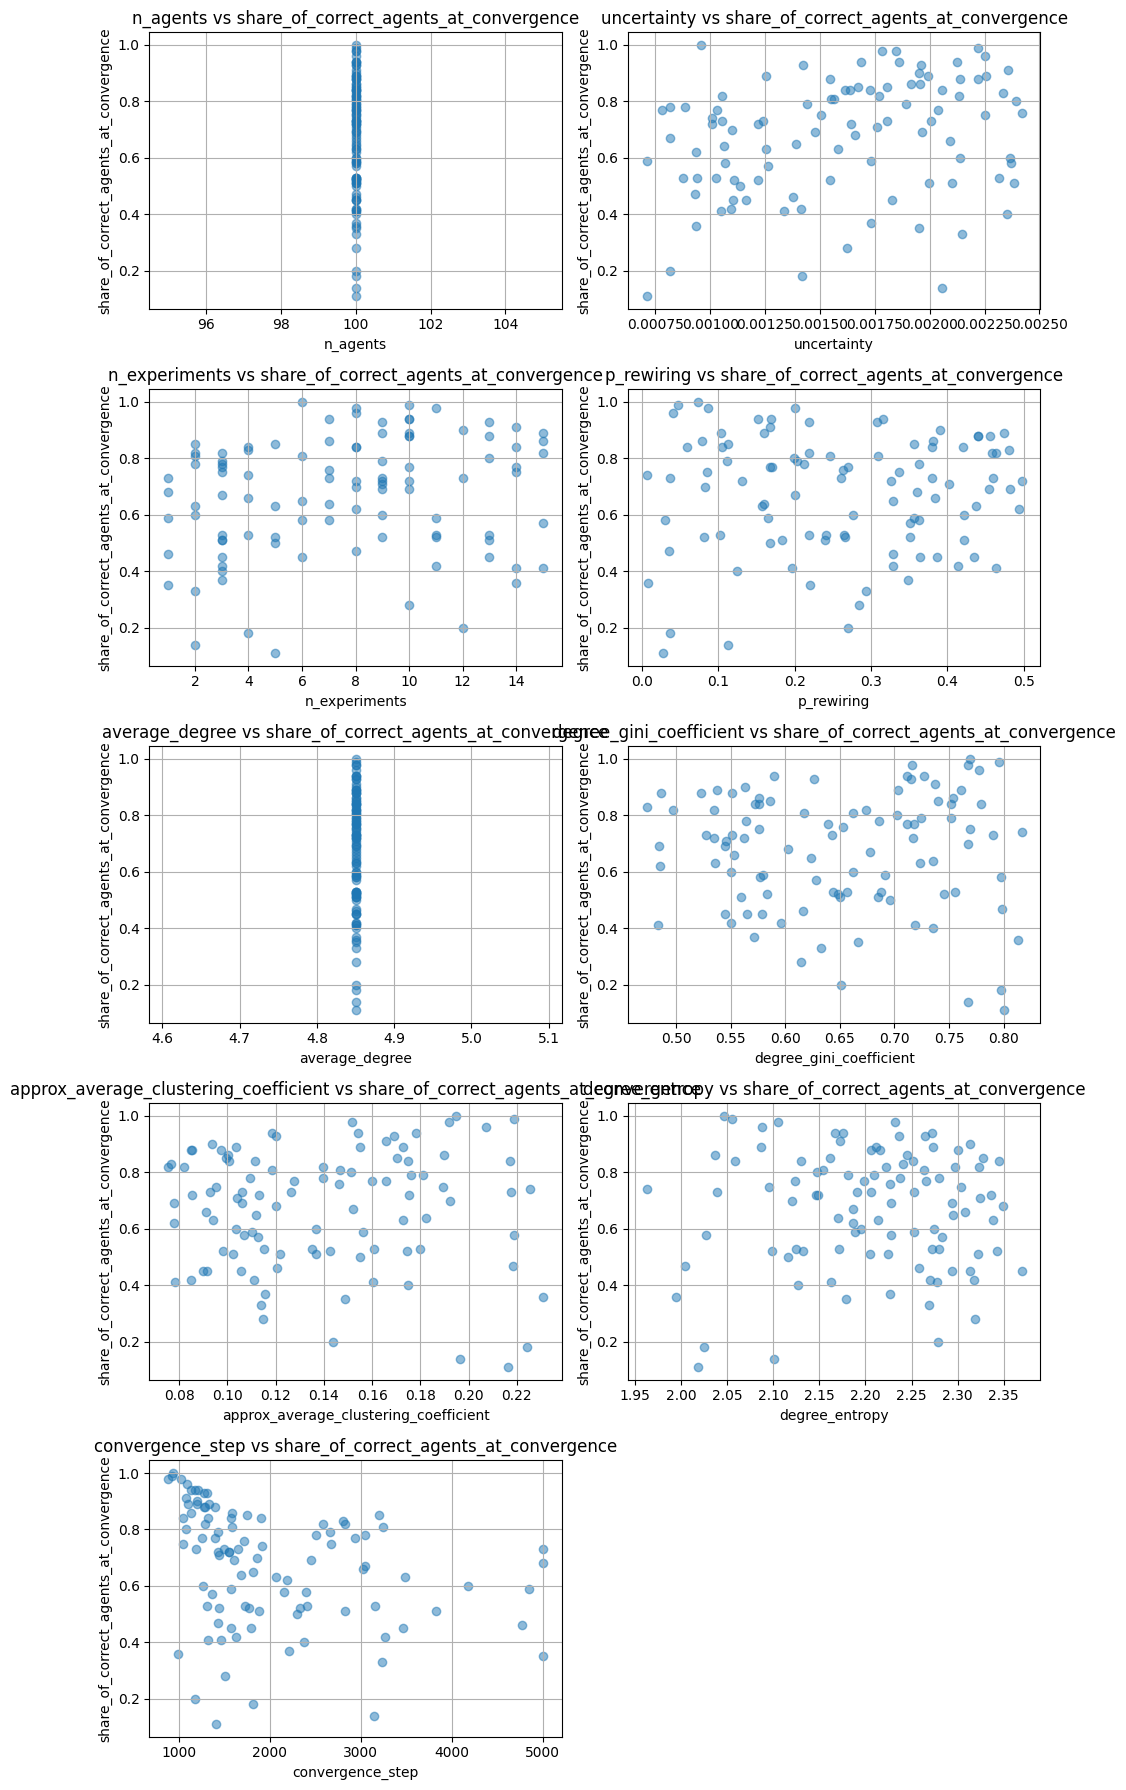

In [7]:
scatter_plot(basic_results_df)

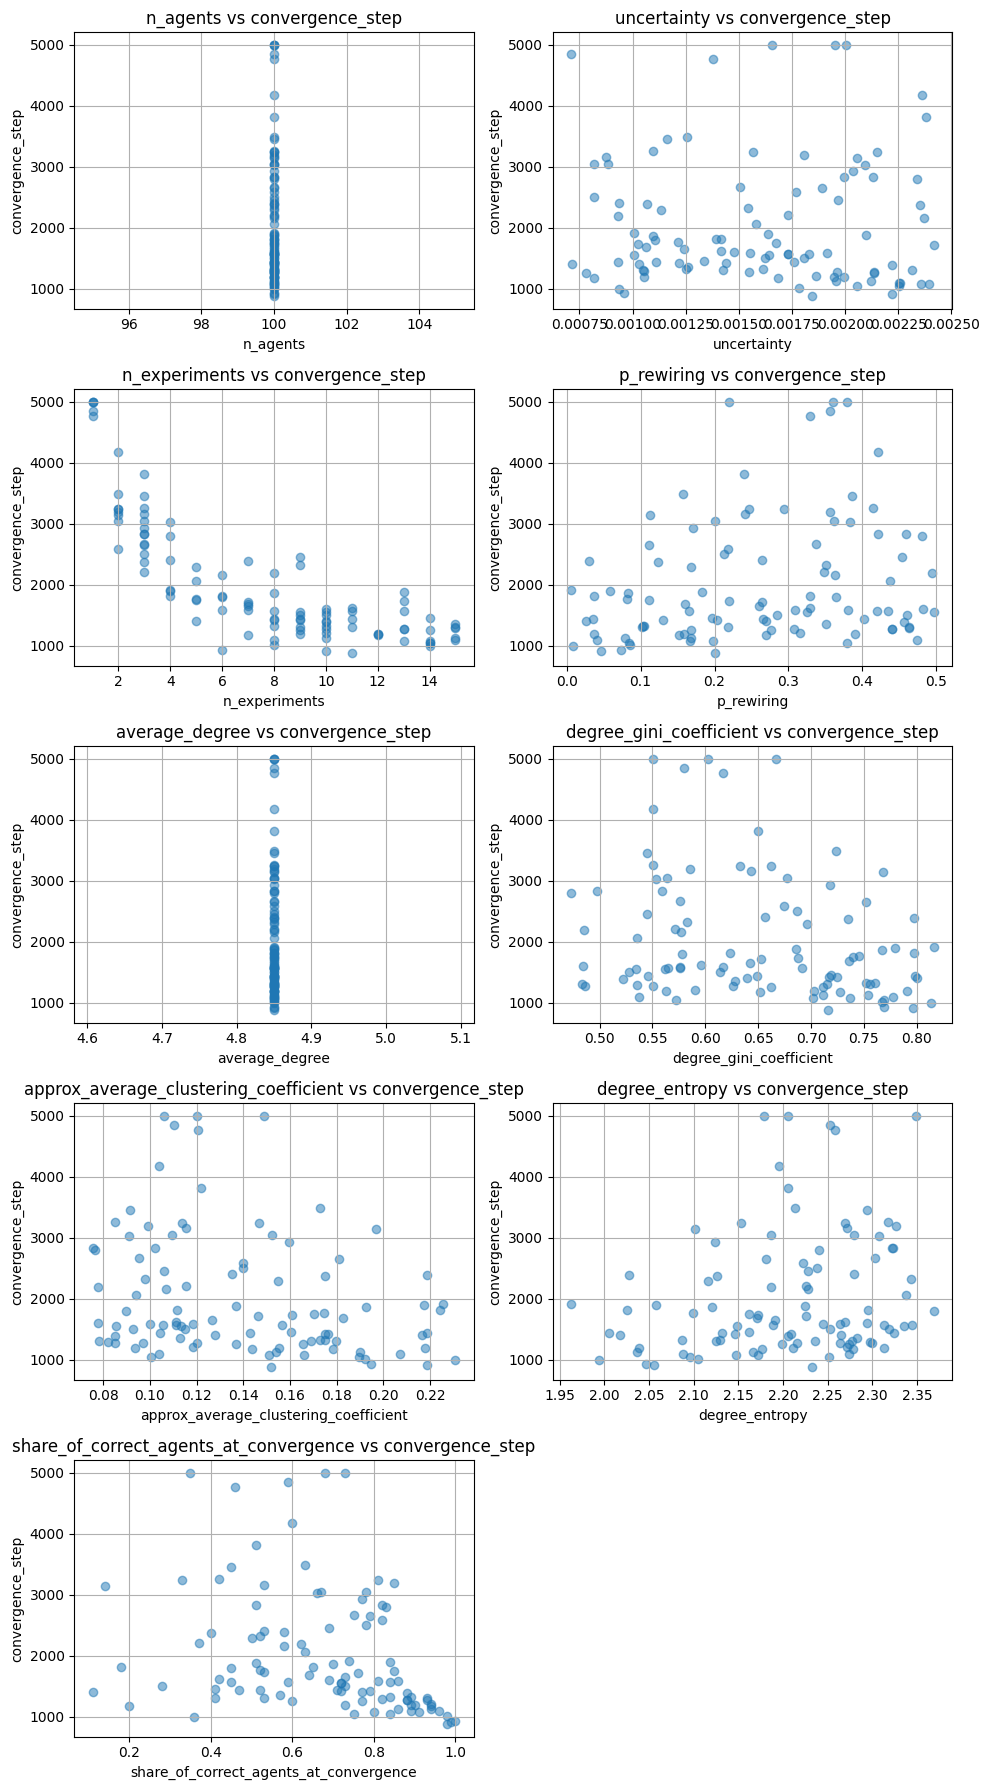

In [8]:
scatter_plot(basic_results_df, target_variable="convergence_step")